<a href="https://colab.research.google.com/github/malnaanah/keras_examples/blob/main/Keras_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Dataset example using Keras and MLP or CNN
Go to the menu:
**Runtime>Change runtime type>Hardware Acceleration>GPU**
to speed the execution of the code


---


Author: Mahmoud Alnaanah (malnaanah@gmail.com)


---

# Defining helper functions

In [52]:
####################### function start ####################################
# Helper function for loading belgian traffic signs data from the internet.
def load_belgian_traffic_signs_data(samples=61): # maximum number of samples is 61
  
  # loadding data
  from skimage import io,img_as_ubyte, transform
  import os
  import numpy as np
  

  if not os.path.exists("BelgiumTSC_Training.zip"):
    !wget -nc https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip
    !unzip -qq BelgiumTSC_Training.zip
  if not os.path.exists("BelgiumTSC_Testing.zip"):  
    !wget -nc https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip
    !unzip -qq BelgiumTSC_Testing.zip

  ROOT_PATH = !pwd
  ROOT_PATH = ROOT_PATH[0]

  train_data_directory = os.path.join(ROOT_PATH, "Training")
  test_data_directory = os.path.join(ROOT_PATH, "Testing")

  
  data_directory = train_data_directory
  directories = sorted([d for d in os.listdir(data_directory)
                        if os.path.isdir(os.path.join(data_directory, d))])
  labels = []
  images = []

  for d in directories[:samples]:
    label_directory = os.path.join(data_directory, d)
    file_names = [os.path.join(label_directory, f) 
                  for f in os.listdir(label_directory) 
                  if f.endswith(".ppm")]
    for f in file_names:
      images.append(img_as_ubyte(transform.resize(io.imread(f), (28, 28))))
      labels.append(int(d))
  images = np.asarray(images)
  labels = np.asarray(labels, dtype='uint8')
  
  x_train = images
  y_train = labels

  
  data_directory = test_data_directory
  directories = sorted([d for d in os.listdir(data_directory)
                        if os.path.isdir(os.path.join(data_directory, d))])
  labels = []
  images = []

  for d in directories[:samples]:
    label_directory = os.path.join(data_directory, d)
    file_names = [os.path.join(label_directory, f) 
                  for f in os.listdir(label_directory) 
                  if f.endswith(".ppm")]
    for f in file_names:
      images.append(img_as_ubyte(transform.resize(io.imread(f), (28, 28))))
      labels.append(int(d))
  images = np.asarray(images)
  labels = np.asarray(labels, dtype='uint8')
  
  x_test = images
  y_test = labels  
  
  return (x_train, y_train), (x_test, y_test)


####################### function start ####################################
# Helper function to plot images
# plot random samples of images
def draw_sample(data_set):
  columns = 8
  rows = 8
  num_samples = columns*rows
#   rows = math.ceil(count/columns)
  plt.figure(figsize=(1.5*columns,1.5*rows))
  if data_set == 'training':
    plt.suptitle('Training set')
    samples = np.random.randint(low=0, high=x_train.shape[0]-1, size=num_samples)
    for i, sample in enumerate(samples,1):
      plt.subplot(rows,columns,i)
      plt.imshow(np.squeeze(x_train[sample]),cmap='gray')
      if class_name != None:
        plt.title("{}".format(class_name[y_train[sample]]))
      else:
        plt.title("{}".format(y_train[sample]))
      plt.axis('off')
  elif data_set == 'testing':
    plt.suptitle('Testing set')
    samples = np.random.randint(low=0, high=x_test.shape[0]-1, size=num_samples)
    for i, sample in enumerate(samples,1):
      plt.subplot(rows,columns,i)
      plt.imshow(np.squeeze(x_test[sample]),cmap='gray')
      if class_name != None:
        plt.title("{}".format(class_name[y_test[sample]]))
      else:
        plt.title("{}".format(y_test[sample]))
      plt.axis('off')
  elif data_set == 'fp_test':
    plt.suptitle('False Prediction set')
    samples = np.random.randint(low=0, high=fp_test.shape[0]-1, size=num_samples)
    for i, sample in enumerate(samples,1):
      plt.subplot(rows,columns,i)
      plt.imshow(np.squeeze(x_test[fp_test[sample]]),cmap='gray')
      if class_name != None:
        plt.title("{}>{}".format(class_name[y_test[fp_test[sample]]],class_name[p_test[fp_test[sample]]])) 
      else:
        plt.title("{}>{}".format(y_test[fp_test[sample]],p_test[fp_test[sample]]))
      plt.axis('off')
  elif data_set == 'tp_test':
    plt.suptitle('True prediction set')
    samples = np.random.randint(low=0, high=tp_test.shape[0]-1, size=num_samples)
    for i, sample in enumerate(samples,1):
      plt.subplot(rows,columns,i)
      plt.imshow(np.squeeze(x_test[tp_test[sample]]),cmap='gray')
      if class_name != None:
        plt.title("{}".format(class_name[p_test[tp_test[sample]]]))
      else:
        plt.title("{}".format(p_test[tp_test[sample]]))
      plt.axis('off')
  else:
    print('Invalid or no data_set')
    return
      
  
  plt.subplots_adjust(wspace=0.3, hspace= .3)
  plt.show()
  return

########################### function start ################################33
# Helper function to plot weights
# only plot the filters of the first conv layer because
# the number of images in the first conv layer (num_f1) is (kernel size, kernel size, 1, num of filters)
# the number of images in the second conv layer is (kernel size, kernel size, num_f1, num of filters)
# which means that each filter from the first convolutional layer has its own set of filters in the next conv layer
# if the model is MLP then the weights of the first hiden layer are plotted

def plot_weights(model):
  for layer in model.layers:
    if layer.name.startswith('conv2d'):
      W = layer.get_weights()[0]
#       W = W - np.min(W)
#       W = W / np.max(W)
      print('Weight shape',W.shape)
      num_filters = W.shape[-1]
      columns = 10
      rows = math.ceil(num_filters/columns)
      plt.figure(figsize=(columns,rows))
      for i in range(num_filters):
        plt.subplot(rows,columns,i+1)
        img = np.squeeze(W[:,:,:,i])
        img = img - np.min(img)
        img = img / np.max(img)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
      #plt.tight_layout()
      plt.show()
      return 
    if layer.name.startswith('dense'):
      W = layer.get_weights()[0]
#       W = W - np.min(W)
#       W = W / np.max(W)
      print('Weight shape',W.shape)
      num_filters = W.shape[-1]
      columns = 10
      rows = math.ceil(num_filters/columns)
      plt.figure(figsize=(columns,rows))
      for i in range(num_filters):
        plt.subplot(rows,columns,i+1)
        img = W[:,i]
        img = img - np.min(img)
        img = img / np.max(img)
        img = img.reshape(x_train.shape[1:])
        img = np.squeeze(img)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
      plt.subplots_adjust(wspace=0.3, hspace= .3)
      #plt.tight_layout()
      plt.show()
      return 


# Selecting the used dataset and nural network type

In [48]:
datasets = {1:'MNIST',2:'CIFAR10',3: 'Belgian_tsigns'}

# Determine the dateset to be used: 1,2, or 3
dataset = datasets[1]

model_types = {1:'CNN',2: 'MLP'}

# Determine the type of the network: 1, or 2
model_type = model_types[1]

# Importing and Data Setup

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import os






if dataset == 'MNIST':
  # Loading data for MNIST dataset
  from keras.datasets import mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  class_name = None
elif dataset == 'CIFAR10':
  # Loading data for MNIST dataset
  from keras.datasets import cifar10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  class_name = {
      0: 'plane',
      1: 'car',
      2: 'bird',
      3: 'cat',
      4: 'deer',
      5: 'dog',
      6: 'frog',
      7: 'horse',
      8: 'ship',
      9: 'truck',
  }
elif dataset == 'Belgian_tsigns':
  # Loading data for Belgian traffic signs
  (x_train, y_train), (x_test, y_test) = load_belgian_traffic_signs_data(samples=30)
  class_name = None
else:
  print('Unkown or no dataset')
  

  
# reshaping gray indexed images
if len(x_train.shape) == 3:
  x_train = np.expand_dims(x_train,3)
  x_test = np.expand_dims(x_test,3)


# squeezing y matrices, 
# this is needed of their dimension is like 10000x1 instead of 10000

y_train = np.squeeze(y_train.astype('uint16'))
y_test = np.squeeze(y_test.astype('uint16'))


# # Categorize outputs if needed 
# no needed in this case since sparse_categorical_crossentropy is used
# y_train = tf.keras.utils.to_categorical(y_train_uc)
# y_test = tf.keras.utils.to_categorical(y_test_uc)

# Rescaling input data between 0 and 1
# (gives better result then using 
# tf.keras.utils.normalize
x_train = x_train.astype('float64')/255
x_test = x_test.astype('float64')/255



              

# Plotting sample images

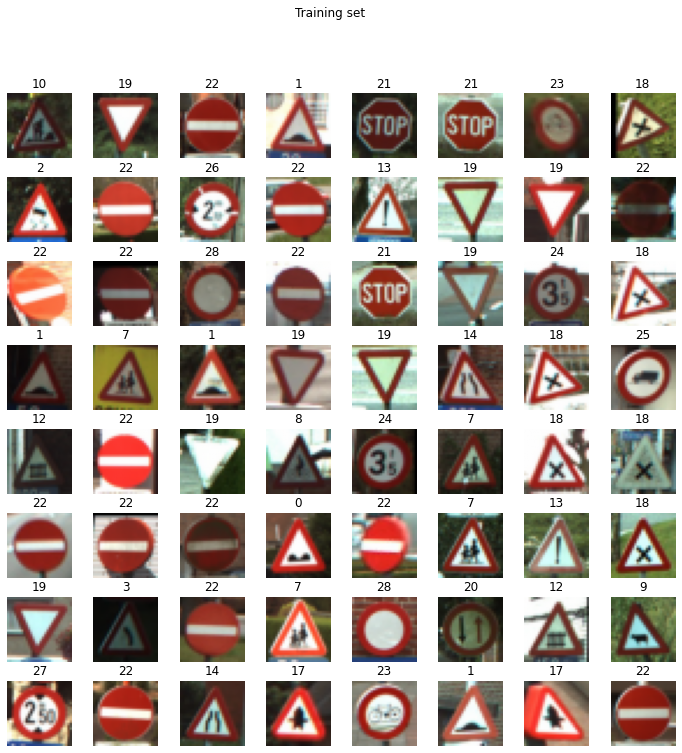

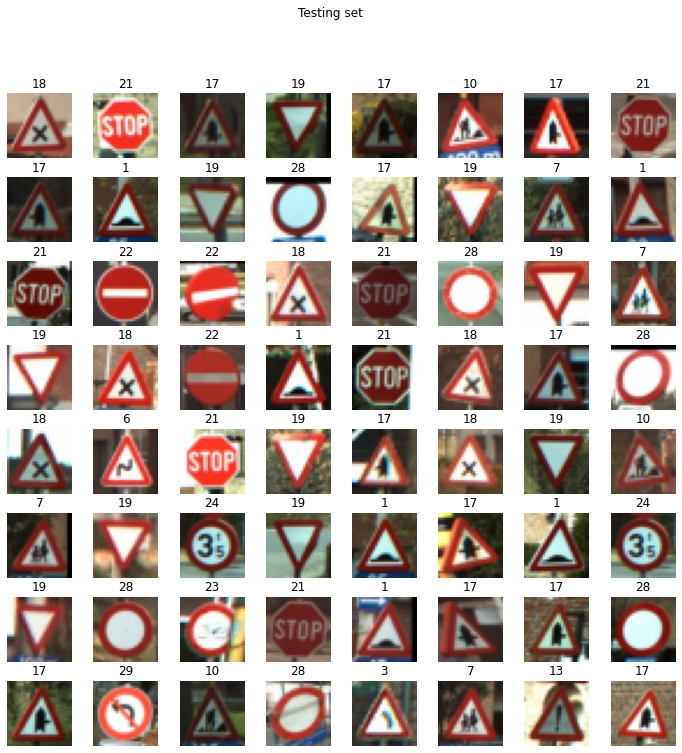

In [54]:
draw_sample('training')
draw_sample('testing')


# Model Definition

In [55]:
model = tf.keras.models.Sequential()


if model_type == 'CNN':

  model.add(tf.keras.layers.Convolution2D(
      filters = 32,
      kernel_size = (5,5),
      activation='relu',
      input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Convolution2D(
      filters = 32,
      activation='relu',
      kernel_size = (3,3)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128,activation='relu'))
  model.add(tf.keras.layers.Dense(len(set(y_train)),activation='softmax'))
elif model_type == 'MLP':
  model.add(tf.keras.layers.Flatten(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(set(y_train)), activation=tf.nn.softmax))
else:
  print('Unknown or no model type')

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy', # the output is a single number and not classified
             metrics=['accuracy']) # metrics to track


# Printing model summary

In [56]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        2432      
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 dropout_5 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

# Plotting the weights for the first conv layer

Weight shape (5, 5, 3, 32)


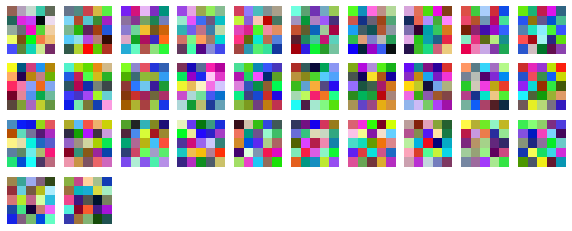

In [57]:
plot_weights(model)

# Fitting

In [58]:
history = model.fit(x_train, y_train, batch_size=100, epochs=15, verbose=1, validation_data=(x_test, y_test))

Epoch 1/2
18/18 [==============================] - 3s 125ms/step - loss: 2.6774 - accuracy: 0.3235 - val_loss: 2.5287 - val_accuracy: 0.3295
Epoch 2/2
18/18 [==============================] - 2s 118ms/step - loss: 1.9835 - accuracy: 0.5046 - val_loss: 2.0700 - val_accuracy: 0.4418


In [60]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Plotting loss and accurecy

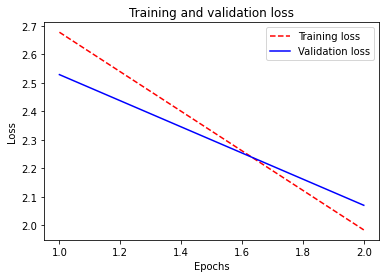

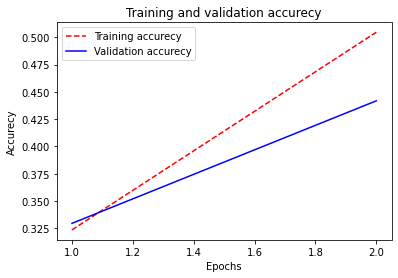

In [61]:
import matplotlib.pyplot as plt

training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

training_acc = model.history.history['accuracy']
validation_acc = model.history.history['val_accuracy']

epochs = range(1, len(training_acc) + 1)


plt.figure()
plt.plot(epochs, training_loss, 'r--', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.figure()
plt.plot(epochs, training_acc, 'r--', label='Training accurecy')
plt.plot(epochs, validation_acc, 'b', label='Validation accurecy')
plt.title('Training and validation accurecy')
plt.xlabel('Epochs')
plt.ylabel('Accurecy')
plt.legend()

plt.show()


# Evaluating the trained model

In [62]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.588812  ;  loss = 1.891996
Validation: accuracy1 = 0.441788  ;  loss = 2.069978


#  Predictions

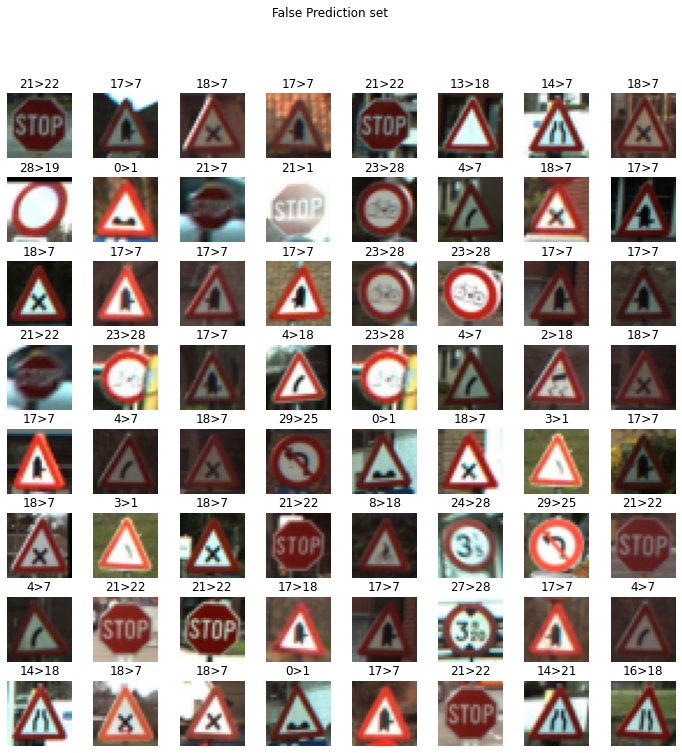

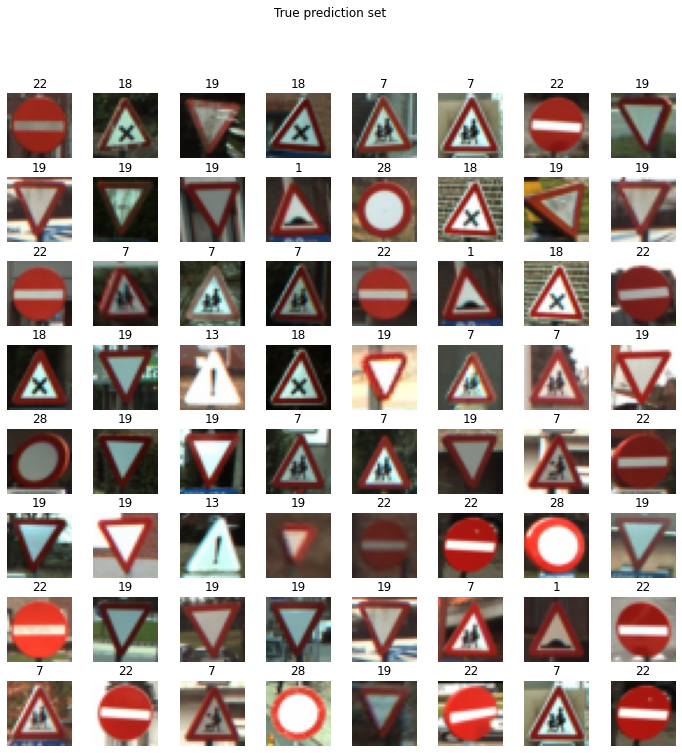

In [63]:
#p_test = model.predict_classes(x_test)
p_test=model.predict(x_test) 
p_test = np.argmax(p_test,axis=1)

# true and flse predictions
tp_test =np.array([i for i in range(len(p_test)) if p_test[i] == y_test[i]])
fp_test = np.array([i for i in range(len(p_test)) if p_test[i] != y_test[i]])

draw_sample('fp_test')
draw_sample('tp_test')

# Plotting wieghts for the first layer

Weight shape (5, 5, 3, 32)


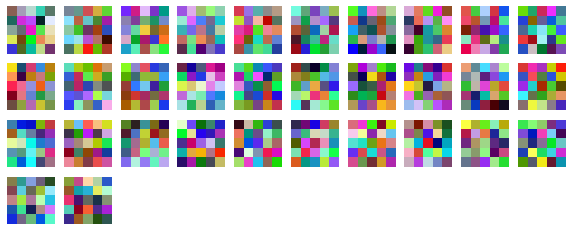

In [64]:
plot_weights(model)

# Loading and saving model into file

In [34]:
# # saving the model into file
# model.save('NAME_MLP.model')

# # loading the model
# new_model = tf.keras.models.load_model('NAME_MLP.model')